# Tasks

## Inputs
### GEOS5
- t2m => t_air_i, t_air_24,t_air_min_24, t_air_max_24
- slp => p_air_i, p_air_24
- u10m,v10m => u_24, u_i
- ps, qv2m => vp_24, vp_i
- swgdn => ra_i, ra_24
- totangstr
- totexttau
- tqv
- to3

### ERA5
- 2m_temperature hourly => t_air_i, t_air_24,t_air_min_24, t_air_max_24
- mean_sea_level_pressure hourly => p_air_i, p_air_24
- 10m_u_component_of_wind, 10m_v_component_of_wind => u_24, u_i
- 2m_dewpoint_temperature => vp_24, vp_i
- surface_solar_radiation_downward_clear_sky => ra_i, ra_24
- surface_pressure hourly(available, not used)

### AgERA5
- 2m_temperature daily => t_air_24,t_air_min_24, t_air_max_24
- 2m_dewpoint_temperature daily => vp_24
- 10m_wind_speed daily => u_24
- solar_radiation_flux daily => ra_24
- 2m_relative_humidity (available, not used)
- vapour_pressure (available, not used)

## Outputs
### Variables in insitu measurements
#### TAHMO (measured at 2m, hourly)
- Air temperature => t_air_i, t_air_24,t_air_min_24, t_air_max_24
- Barometric pressure => p_air_i, p_air_24
- Relative humidity => vp_24, vp_i
- Wind gust => u_24, u_i
- Solar radiation => ra_i, ra_24
#### WASCAL (measured at 2m, hourly)
- Air temperature => t_air_i, t_air_24,t_air_min_24, t_air_max_24
- Air pressure => p_air_i, p_air_24
- Relative humidity => vp_24, vp_i
- Horizonal windspeed => u_24, u_i
- Incoming shortwave radiation => ra_i, ra_24

### Variables in ETLook
#### Daily
- t_air_24
- t_air_min_24
- t_air_max_24
- p_air_24
- u_24
- qv_24 or rh_24 or t_dew => vp_24
- ra_24

### Instantaneous (Hourly) 
- t_air_i
- p_air_i
- u_i
- qv_i or rh_i or t_dew_i => vp_i
- ra_i_toa 

# Import

In [1]:
import xarray as xr
import os
import glob
import numpy as np
import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pywapor.et_look_v2_v3.meteo as meteo
from pywapor.et_look_v2_v3 import constants as c
import scipy.stats
from osgeo import gdal
from osgeo import osr

# Pre-processing

## Units conversion

In [ ]:
def kelvin_to_celsius(t_k, attrs={}):
    '''
    Convert kelvin to celcius
    ---
    Parameters
    t_k: xr.DataArray
    ---
    Results
    t_c
    '''
    t_c = t_k - 273.15
    t_c.name=t_k.name
    attrs['units'] = 'degree Celsius'
    t_c.attrs=attrs
    return t_c

def Pa_to_mbar(p_Pa, attrs={}):
    '''
    Convert Pa to mbar
    ---
    Parameters
    t_k: xr.DataArray
        air temperature (Kelvin)
    ---
    Results
    t_c
        air temperature (Celsius degree)
    '''
    p_mbar = p_Pa * 0.01
    p_mbar.name=p_Pa.name
    attrs['units'] = 'mbar'
    p_mbar.attrs=attrs
    return p_mbar 

def J_per_day_to_W(ra_j, attrs={}):
    '''
    Convert J d-1 to W
    ---
    Parameters
    t_k: xr.DataArray
    ---
    Results
    t_c
    '''
    ra_w = ra_j / 86400
    ra_w.name=ra_j.name
    attrs['units'] = 'W m-2'
    ra_w.attrs=attrs
    return ra_w

def J_per_dt_to_W(ra_j, dt=3600, attrs={}):
    '''
    Convert J dt-1 to W
    ---
    Parameters
    ra_j: xr.DataArray
    ---
    Results
    ra_w
    '''
    ra_w = ra_j / dt
    ra_w.name=ra_j.name
    attrs['units'] = 'W m-2'
    ra_w.attrs=attrs
    return ra_w

In [9]:
def windspeed_from_components(u_array, v_array, attrs={}):  
    '''
    Compute windspeed from components
    ---
    Parameters
    u_array : xr.DataArray
    v_array : xr.DataArray
    attrs : Dictionary
    ---
    Results
    u : xr.DataArray
    '''
    # u10m = u10m * u10m.scale_factor + u10m.add_offset
    # u_array = u10m.data
    # v10m = v10m * v10m.scale_factor + v10m.add_offset
    # v_array = v10m.data
    u = np.sqrt(u_array ** 2 + v_array ** 2)
    u.name= 'u'
    attrs['long_name'] = '10-meter_wind_speed'
    attrs['method'] = 'np.sqrt(u_array ** 2 + v_array ** 2)'
    u.attrs= attrs
    return u

## ETLook functions

In [ ]:
def air_pressure(z, p_air_0, attrs={}):
    '''
    Calculate surface air pressure from sea level air pressure and elevation
    ---
    Parameters
    z : xr.DataArray
        elevation (m)
    slp: xr.DataArray
        sea level pressure (mbar)
    ---
    Results
    p_air : xr.DataArray
        surface air pressure (mbar)
    '''
    p_air = meteo.air_pressure(z, p_air_0)
    p_air.name = 'p_air'
    attrs['long_name'] = 'surface_air_pressure'
    attrs['units'] = 'mbar'
    attrs['method'] = 'pywapor.et_look_v2_v3.air_pressure'
    p_air.attrs=attrs
    return p_air

In [ ]:
def vapour_pressure_from_specific_humidity(p_air, qv, attrs={}):
    '''
    Calculate vapour pressure (vp) from specific humidity
    ---
    Parameters
    p_air: xr.DataArray
        surface air pressure (mbar)
    qv: xr.DataArray
        specific humidity (kg kg-1)
    ---
    Results
    vp: xr.DataArray
        vapour pressure (mbar)
    '''
    vp = meteo.vapour_pressure_from_specific_humidity(qv,p_air)
    vp.name = 'vp' 
    attrs['long_name'] = 'actual_vapour_pressure'
    attrs['units'] = 'mbar'
    attrs['method'] = 'pywapor.et_look_v2_v3.vapour_pressure_from_specific_humidity'
    vp.attrs = attrs
    return vp

def vapour_pressure_from_dewpoint(t_dew, attrs={}):
    '''
    Calculate vapour pressure (vp) from specific humidity
    ---
    Parameters
    t_dew: xr.DataArray
        dew point temperature (Celsius degree)
    ---
    Results
    vp: xr.DataArray
        vapour pressure (mbar)
    '''
    vp = meteo.vapour_pressure_from_dewpoint(t_dew)
    vp.name = 'vp'    
    attrs['long_name'] = 'actual_vapour_pressure'
    attrs['units'] = 'mbar'
    attrs['method'] = 'pywapor.et_look_v2_v3.vapour_pressure_from_dewpoint'
    vp.attrs = attrs
    return vp
    
def vapour_pressure_from_relative_humidity(rh, t_air, attrs={}):
    '''
    Calculate vapour pressure (vp) from specific humidity
    ---
    Parameters
    rh: xr.DataArray
        relative humidity (%)
    t_air: xr.DataArray
        air temperature (Celsius degree)
    ---
    Results
    vp: xr.DataArray
        vapour pressure (mbar)
    '''
    svp = meteo.saturated_vapour_pressure(t_air)
    vp = meteo.vapour_pressure(svp, rh)
    vp.name = 'vp'    
    attrs['long_name'] = 'actual_vapour_pressure'
    attrs['units'] = 'mbar'
    attrs['method'] = 'pywapor.et_look_v2_v3.vapour_pressure from relative humidity'
    vp.attrs = attrs
    return vp

# Aggregation

In [16]:
def check_files_in_folder(folder_path, file_name_list,extension=None,required_size=1):
    # Get the list of files in the folder
    folder_files = os.listdir(folder_path)    
    missing_files = []
    # Check if all desired files are present and have the required size
    for file_name in file_name_list:
        if extension:
            file_name = file_name + '.' + extension
        file_path = os.path.join(folder_path, file_name)
        
        if file_name not in folder_files:
            missing_files.append(file_name)
        elif os.path.getsize(file_path) < required_size:
            missing_files.append(file_name)

    if not missing_files:
        return True
    else:
        print(missing_files)
        return False

## Temporal aggregation

In [1]:
def get_periods_dates(start_date, end_date,
                          freq='M'):
    start_range = pd.date_range(start=start_date, end=end_date, freq=freq+'S' )
    end_range = pd.date_range(start=start_date, end=end_date, freq=freq )
    periods_dates= list(zip(start_range, end_range))
    return periods_dates
    
def get_filenames_as_dates(start_date, end_date,
                          freq='D', 
                          date_format='%Y-%m-%d',
                          prefix='*',
                          suffix='*.nc',                          
                         ):
    date_range = pd.date_range(start=start_date, end=end_date, freq=freq )
    formatted_dates = [date.strftime(date_format) for date in date_range]
    filenames = [prefix+date+suffix for date in formatted_dates] 
    return filenames
    

def aggregate_by_time(input_fhs,output_file,
                      resample_size = 'D',
                      method='mean',skipna=True,attrs={}):
    ds = xr.open_mfdataset(input_fhs,engine='netcdf4')
    ds_agg=ds.resample(time=resample_size).mean(skipna=skipna).compute()
    attrs['method']='aggregate_by_time, resample size: ' + resample_size
    ds_agg.attrs=attrs
    ds_agg.to_netcdf(output_file) 
    ds.close()
    return ds_agg
            

## Spatial aggregation

Method to interpolate: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.interp_like.html

In [ ]:
def spatial_aggregate(source_nc, target_nc, 
                      save_nc, attrs={},
                      method='linear'):
    source_ds = xr.open_dataset(source_nc)
    target_ds = xr.open_dataset(target_nc)
    target_grid = target_ds.coords
    try:
        resampled_data = source_ds.interp(lat = target_grid['lat'],
                                          lon = target_grid['lon'],
                                          method = method)
    except:
        resampled_data = source_ds.interp(lat = target_grid['latitude'],
                                          lon = target_grid['longitude'],
                                          method = method)        
    attrs['method']='xr.Dataset.interp '+method
    resampled_data.attrs = attrs
    resampled_data.to_netcdf(save_nc)

# Spatial intercomparison

## Graphs matrix

In [ ]:
def subplot_image(input_da, ax, title=None, add_latlon_grid=True, xticks=True, yticks=True,**kwargs):
    if type(input_da) is xr.core.dataarray.DataArray:
        im = input_da.plot(ax=ax,
                           add_labels=True, 
                           add_colorbar=False, 
                           xticks=[], yticks=[],
                           **kwargs)
    else:
        im = ax.imshow(input_da, 
                       add_labels=False, 
                       add_colorbar=False, 
                       extent=[input_da.lon.min(), input_da.lon.max(), input_da.lat.min(), input_da.lat.max()],
                       **kwargs)
        
    ax.set_frame_on(False)
    if add_latlon_grid and hasattr(input_da, 'lat') and hasattr(input_da, 'lon'):
        # Set latitude and longitude grid lines based on the extent of the DataArray
        lon_ticks = list(range(int(input_da.lon.min()), int(input_da.lon.max()) + 10, 10))
        lat_ticks = list(range(int(input_da.lat.min()), int(input_da.lat.max()) + 10, 10))
        ax.set_xticks(lon_ticks)
        ax.set_yticks(lat_ticks)
        if not xticks:
            ax.set_xticklabels([])    
        if not yticks:
            ax.set_yticklabels([])    
        ax.grid(True, linestyle='-', linewidth=0.5, color='black', alpha=0.3)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    
    if title:
        ax.set_title(title)
    
    return im  
    
def subplot_image_cbar(im, ax, fig, label=None):
    cbar = fig.colorbar(im, cax=ax, extend='both', 
                 orientation='horizontal', pad=0.1)
    cbar.ax.set_xlabel(label)  
    



In [ ]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

# fig = plt.figure()
# using_mpl_scatter_density(fig, x1, x3)
# plt.show()

In [2]:
from matplotlib import cm
import datashader
from datashader.mpl_ext import dsshow
from datashader import Canvas

def subplot_density_scatter( x , y, ax, nmax=80, title=None,
                            spines_opt=None, 
                            axlim=None,
                            **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    source: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density
    """
    df = pd.DataFrame(dict(x=x, y=y))
  
    dsartist = dsshow(
        df,
        datashader.Point("x", "y"),
        datashader.count(),
        vmin=0,
        vmax=nmax, #max number of pixels
        norm="linear",
        aspect="auto",
        cmap='magma',
        ax=ax,
    )
    ## plot 1:1 line
    ax.plot(axlim,axlim,color='black')
    ## plot linear regression line
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b, color='red')
    ## add regression function
    if b<0:
        text = f'$y = {m:.2f} \cdot x {b:.2f}$'
    else:
        text = f'$y = {m:.2f} \cdot x + {b:.2f}$'
    ax.text(0.7, 0.90, text, transform=ax.transAxes, fontsize=12, 
            ha='right', va='bottom')
    ## calculate metrics
    metrics = calc_metrics(x,y)
    print(metrics)
    metrics_text= metrics_line(metrics)
    ax.text(0.95, 0.05, metrics_text, transform=ax.transAxes, fontsize=12, 
            ha='right', va='bottom')    
    ## configure axis limits and visibility
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if axlim:
        ax.set_xlim(axlim[0],axlim[1])
        ax.set_ylim(axlim[0],axlim[1])
    if spines_opt==0:
        ax.spines['bottom'].set_visible(False)
        ax.set_ylabel('y')
    if spines_opt==1:
        ax.spines['left'].set_visible(False)
        ax.set_xlabel('x')
    if spines_opt is None:
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    if title:
        ax.set_title(title)    
    return ax,dsartist

def subplot_scatter_cbar(dsartist,ax, fig, label):
    cbar = fig.colorbar(dsartist, 
                        cax=ax,
                        extend='max',
                       orientation='horizontal',pad=0.1)
    cbar.ax.set_xlabel(label)    

In [6]:
import matplotlib.gridspec as gridspec

def create_graph_matrix_3(figsize = [20,20]):
    '''
    create a graph matrix of 3x3
    with legend on the bottom
    '''
    fig = plt.figure(figsize =(figsize))
    gs = gridspec.GridSpec(30, 3) #legend is 1:10 of plot
    gs.update(wspace = 0.2, hspace = 0.2)
    ## Diagonal: average maps
    ax1 = plt.subplot(gs[:8, 0])
    ax2 = plt.subplot(gs[10:18, 1])
    ax3 = plt.subplot(gs[20:28, 2])
    diagon_axs = [ax1,ax2,ax3]
    ## Upper triangular: different maps
    ax4 = plt.subplot(gs[:8, 1])
    ax5 = plt.subplot(gs[:8, 2])
    ax6 = plt.subplot(gs[10:18, 2])    
    uptriang_axs = [ax4,ax5,ax6]
    ## Lower triangular: scatter plots
    ax7 = plt.subplot(gs[10:18, 0])
    ax8 = plt.subplot(gs[20:28, 0])
    ax9 = plt.subplot(gs[20:28, 1])   
    lotriang_axs = [ax7, ax8, ax9]    
    ## legends
    ax10 = plt.subplot(gs[29:, 0])
    ax11 = plt.subplot(gs[29:, 1])
    ax12 = plt.subplot(gs[29:, 2])
    legends_axs = [ax10,ax11,ax12]    
    return fig,diagon_axs,uptriang_axs,lotriang_axs,legends_axs

In [1]:
def create_graph_matrix_2(figsize = [15,10]):
    '''
    create a graph matrix of 2x2
    with legend on the bottom
    '''
    fig = plt.figure(figsize =(figsize))
    gs = gridspec.GridSpec(21, 2) #legend is 1:10 of plot
    gs.update(wspace = 0.2, hspace = 0.2)
    ## Diagonal: average maps
    ax1 = plt.subplot(gs[3:10, 0])
    ax2 = plt.subplot(gs[12:19, 1])
    diagon_axs = [ax1,ax2]
    ## Upper triangular: different maps
    ax2 = plt.subplot(gs[3:10, 1])   
    uptriang_axs = [ax2]
    ## Lower triangular: scatter plots
    ax3 = plt.subplot(gs[12:19, 0])
    lotriang_axs = [ax3]    
    ## legends
    ax4 = plt.subplot(gs[0:1, 0])
    ax5 = plt.subplot(gs[0:1, 1])
    ax6 = plt.subplot(gs[20:, 0])
    legends_axs = [ax4,ax5,ax6]    
    return fig,diagon_axs,uptriang_axs,lotriang_axs,legends_axs

In [1]:
def create_graph_matrix_4(figsize = [25,20]):
    '''
    create a graph matrix of 4x4
    with legend on the bottom
    '''
    fig = plt.figure(figsize =(figsize))
    gs = gridspec.GridSpec(56, 4) #legend is 1:10 of plot
    gs.update(wspace = 0.2, hspace = 0.2)
    ## Diagonal: average maps
    ax1 = plt.subplot(gs[4:14, 0])
    ax2 = plt.subplot(gs[17:27, 1])
    ax3 = plt.subplot(gs[30:40, 2])
    ax4 = plt.subplot(gs[43:53, 3])
    diagon_axs = [ax1,ax2,ax3,ax4]
    ## Upper triangular: different maps
    ax12 = plt.subplot(gs[4:14, 1])
    ax13 = plt.subplot(gs[4:14, 2])
    ax14 = plt.subplot(gs[4:14, 3])
    ax23 = plt.subplot(gs[17:27, 2])
    ax24 = plt.subplot(gs[17:27, 3])
    ax34 = plt.subplot(gs[30:40, 3])
    uptriang_axs = [ax12, ax13, ax14, ax23,ax24, ax34]
    ## Lower triangular: scatter plots
    ax21 = plt.subplot(gs[17:27, 0])
    ax31 = plt.subplot(gs[30:40, 0])
    ax32 = plt.subplot(gs[30:40, 1])
    ax41 = plt.subplot(gs[43:53, 0])
    ax42 = plt.subplot(gs[43:53, 1])
    ax43 = plt.subplot(gs[43:53, 2])     
    lotriang_axs = [ax21, ax31, ax32, ax41, ax42, ax43]   
    ## legends
    ax5 = plt.subplot(gs[0:1, 0])
    ax6 = plt.subplot(gs[0:1, 3])
    ax7 = plt.subplot(gs[55:56, 0])
    legends_axs = [ax5,ax6,ax7]    
    return fig,diagon_axs,uptriang_axs,lotriang_axs,legends_axs

## Hovmoller graph

In [ ]:
def plot_hovmoller_month(da, title, dimension = ["lon","lat"],
                   ax=None,varname='Variable',cmap ='RdYlBu',
                         show_cmap=True,**kwargs):
    da_monthly = da.groupby("time.month").mean()
    da_mean = da_monthly.mean(dim = dimension[0])
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    if show_cmap:
        da_mean.plot(x="month",y=dimension[1], ax=ax,
                     cmap =cmap,
                      cbar_kwargs = {
                          'label': varname,
                          'extend': 'both'
                      },
                    **kwargs)
    else:
         da_mean.plot(x="month",y=dimension[1], ax=ax,
                     cmap =cmap,
                      add_colorbar=False,
                    **kwargs)       
    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel("Latitude (degree North)") 
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                        'Jul','Aug','Sep', 'Oct', 'Nov', 'Dec'])
    
def plot_hovmoller(da, title, dimension = ["lon","lat"],
                   ax=None,varname='Variable',cmap ='RdYlBu',
                   show_cmap=True, **kwargs):    
    da_mean = da.mean(dim = dimension[0])
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    if show_cmap:
        da_mean.plot(x="time",y=dimension[1], ax=ax,
                     cmap =cmap,
                      cbar_kwargs = {
                          'label': varname,
                          'extend': 'both'
                      },
                    **kwargs)
    else:
        da_mean.plot(x="time",y=dimension[1], ax=ax,
                     cmap =cmap,
                      add_colorbar=False,
                    **kwargs)        
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Latitude (degree North)") 

# Point-to-Pixel Validation

## Metrics

In [ ]:
def calc_pearson_squared(x,y):
    r, p = scipy.stats.pearsonr(x, y)
    return r**2, p
def calc_nse(x,y):
    numerator = np.sum((x - y)**2)
    denominator = np.sum((x - np.mean(x))**2)
    return 1 - numerator / denominator
def calc_bias(x,y):
    return np.mean(x - y)
def calc_pbias(x,y):
    return calc_bias(x,y)*100/np.mean(x)
def calc_rmse(x,y):
    return np.sqrt(np.mean((x - y)**2))
def calc_metrics(x,y):
    metrics={}
    metrics['r2']=calc_pearson_squared(x,y)[0]
    # metrics['p-value']=calc_pearson_squared(x,y)[1]
    # metrics['nse']=calc_nse(x,y)
    metrics['bias']=calc_bias(x,y)
    metrics['pbias']=calc_pbias(x,y)
    metrics['rmse']=calc_rmse(x,y)
    return metrics

In [ ]:
def metrics_line(metrics):
    pretty = {
        'r2': '$r^2$',
       'bias': 'BIAS',
       'pbias': 'PBIAS',
       'rmse':'RMSE'
    }
    text_lists = []
    for key,value in metrics.items():
        if (key is 'r2') & (value > 0.99):
            text_lists.append(f'{pretty[key]} > 0.99')
        else:
            text_lists.append(f'{pretty[key]} = {value:.2f}')
    formatted_text = '\n'.join(text_lists)
        
    #formatted_text = '\n'.join([f'{pretty[key]} = {value:.2f}' for key, value in metrics.items()])
    return formatted_text

## Plot performance comparison

In [ ]:
def plot_hist(ts, v = (-1,-0.1,0.1,1), bins = 20,
             xlabel = "metrics", ylabel ="Number of stations"):
    plt.hist(ts,range=(v[0],v[-1]),
             bins = bins)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.axvspan(v[1],v[2],facecolor='yellow',
                alpha=0.2,zorder=-100)
    plt.axvspan(v[0],v[1],facecolor='green',
                alpha=0.2,zorder=-100)
    plt.axvspan(v[2],v[3],facecolor='red',
                alpha=0.2,zorder=-100)
    plt.xlim(v[0],v[-1])

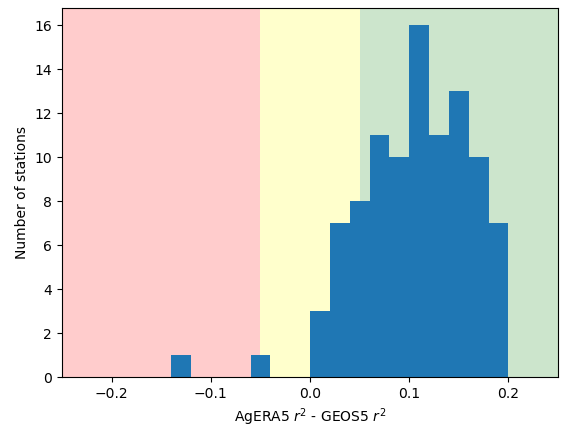

# GeoTiff functions

In [1]:
def GetGeoInfo(fh, subdataset = 0):
    """
    Substract metadata from a geotiff, HDF4 or netCDF file.
    
    Parameters
    ----------
    fh : str
        Filehandle to file to be scrutinized.
    subdataset : int, optional
        Layer to be used in case of HDF4 or netCDF format, default is 0.
        
    Returns
    -------
    driver : str
        Driver of the fh.
    NDV : float
        No-data-value of the fh.
    xsize : int
        Amount of pixels in x direction.
    ysize : int
        Amount of pixels in y direction.
    GeoT : list
        List with geotransform values.
    Projection : str
        Projection of fh.
    """
    SourceDS = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = SourceDS.GetDriver().ShortName
    if Type == 'HDF4' or Type == 'netCDF':
        SourceDS = gdal.Open(SourceDS.GetSubDatasets()[subdataset][0])
    NDV = SourceDS.GetRasterBand(1).GetNoDataValue()
    xsize = SourceDS.RasterXSize
    ysize = SourceDS.RasterYSize
    GeoT = SourceDS.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(SourceDS.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return driver, NDV, xsize, ysize, GeoT, Projection

def OpenAsArray(fh, bandnumber = 1, dtype = 'float32', nan_values = False):
    """
    Open a map as an numpy array. 
    
    Parameters
    ----------
    fh: str
        Filehandle to map to open.
    bandnumber : int, optional 
        Band or layer to open as array, default is 1.
    dtype : str, optional
        Datatype of output array, default is 'float32'.
    nan_values : boolean, optional
        Convert he no-data-values into np.nan values, note that dtype needs to
        be a float if True. Default is False.
        
    Returns
    -------
    Array : ndarray
        Array with the pixel values.
    """
    datatypes = {"uint8": np.uint8, "int8": np.int8, "uint16": np.uint16, "int16":  np.int16, "Int16":  np.int16, "uint32": np.uint32,
    "int32": np.int32, "float32": np.float32, "float64": np.float64, "complex64": np.complex64, "complex128": np.complex128,
    "Int32": np.int32, "Float32": np.float32, "Float64": np.float64, "Complex64": np.complex64, "Complex128": np.complex128,}
    DataSet = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    if Type == 'HDF4':
        Subdataset = gdal.Open(DataSet.GetSubDatasets()[bandnumber][0])
        NDV = int(Subdataset.GetMetadata()['_FillValue'])
    else:
        Subdataset = DataSet.GetRasterBand(bandnumber)
        NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(datatypes[dtype])
    if nan_values:
        Array[Array == NDV] = np.nan
    return Array

def CreateGeoTiff(fh, Array, driver, NDV, xsize, ysize, GeoT, Projection, explicit = True, compress = None):
    """
    Creates a geotiff from a numpy array.
    
    Parameters
    ----------
    fh : str
        Filehandle for output.
    Array: ndarray
        Array to convert to geotiff.
    driver : str
        Driver of the fh.
    NDV : float
        No-data-value of the fh.
    xsize : int
        Amount of pixels in x direction.
    ysize : int
        Amount of pixels in y direction.
    GeoT : list
        List with geotransform values.
    Projection : str
        Projection of fh.    
    """
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
    "Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    if compress != None:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name], ['COMPRESS={0}'.format(compress)])
    else:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name])
    if NDV is None:
        NDV = -9999
    if explicit:
        Array[np.isnan(Array)] = NDV
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    DataSet = None
    if "nt" not in Array.dtype.name:
        Array[Array == NDV] = np.nan


def MatchProjResNDV(source_file, target_fhs, output_folder, resample = 'near', dtype = 'float32', scale = None, ndv_to_zero = False):
    """
    Matches the projection, resolution and no-data-value of a list of target-files
    with a source-file and saves the new maps in output_folder.
    
    Parameters
    ----------
    source_file : str
        The file to match the projection, resolution and ndv with.
    target_fhs : list
        The files to be reprojected.
    output_folder : str
        Folder to store the output.
    resample : str, optional
        Resampling method to use, default is 'near' (nearest neighbour).
    dtype : str, optional
        Datatype of output, default is 'float32'.
    scale : int, optional
        Multiple all maps with this value, default is None.
    
    Returns
    -------
    output_files : ndarray 
        Filehandles of the created files.
    """
    dst_info=gdal.Info(gdal.Open(source_file),format='json')
    output_files = np.array([])
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for target_file in target_fhs:
        folder, fn = os.path.split(target_file)
        src_info=gdal.Info(gdal.Open(target_file),format='json')
        output_file = os.path.join(output_folder, fn)
        gdal.Warp(output_file,target_file,format='GTiff',
                      srcSRS=src_info['coordinateSystem']['wkt'],
                      dstSRS=dst_info['coordinateSystem']['wkt'],
                      srcNodata=src_info['bands'][0]['noDataValue'],
                      dstNodata=dst_info['bands'][0]['noDataValue'],
                      width=dst_info['size'][0],
                      height=dst_info['size'][1],
                      outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                                    dst_info['cornerCoordinates']['lowerLeft'][1],
                                    dst_info['cornerCoordinates']['upperRight'][0],
                                    dst_info['cornerCoordinates']['upperRight'][1]),
                      outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
                      resampleAlg=resample)
        output_files = np.append(output_files, output_file)
        if not np.any([scale == 1.0, scale == None, scale == 1]):
            driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
            DATA = OpenAsArray(output_file, nan_values = True) * scale
            CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
        if ndv_to_zero:
            driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
            DATA = OpenAsArray(output_file, nan_values = False)
            DATA[DATA == NDV] = 0.0
            CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
    return output_files



# Uncertainty propagation

## Taylor uarrays

In [ ]:
def plot_uarray(uarray):
    '''
    plot nominal value and standard deviation    
    '''
    fig,axs=plt.subplots(1,2)    
    
    # Plot for array1
    im1 = axs[0].imshow(unumpy.nominal_values(uarray), cmap='viridis')
    axs[0].set_title('Nominal values')
    fig.colorbar(im1, ax=axs[0])

    # Plot for array2
    im2 = axs[1].imshow(unumpy.std_devs(uarray), cmap='viridis')
    axs[1].set_title('Standard deviation')
    fig.colorbar(im2, ax=axs[1])
    
    plt.subplots_adjust(wspace=0.5)
    plt.show()
def create_mask(xarray_dataset, shapefile, invert=True):
    shape = gpd.read_file(shapefile)
    # Assuming the dataset contains 'longitude' and 'latitude' or similar
    transform = rasterio.transform.from_bounds(
        xarray_dataset.longitude.min().item(), xarray_dataset.latitude.min().item(),
        xarray_dataset.longitude.max().item(), xarray_dataset.latitude.max().item(),
        xarray_dataset.dims['longitude'], xarray_dataset.dims['latitude']
    )
    
    width = int(xarray_dataset.dims['longitude'])
    height = int(xarray_dataset.dims['latitude'])
    
    # Creating the mask
    mask = geometry_mask([geom['geometry'] for geom in shape.iterfeatures()],
                         out_shape=(height, width),
                         transform=transform,
                         invert=invert)  # invert=False to mask outside the geometries
    return mask

def da_to_uarray(da_mean,da_std):
    '''
    da has only 2-D (lon, lat) and 1 variable
    '''
    uarray=unumpy.uarray(da_mean.values,da_std.values)
    return uarray

def uarray_to_da(uarray,da_temp,mask=None,attrs={}):
    '''
    convert uarray into dataarray
    da_temp has only 2-D (lon, lat) and 1 variable, and same x*y size as uarray
    mask is shapefile path
    '''
    ds = xr.Dataset({
        'mean': xr.DataArray(unumpy.nominal_values(uarray),
                             dims=da_temp.dims,
                             coords=da_temp.coords,
                             attrs=attrs),
         'std': xr.DataArray(unumpy.std_devs(uarray),
                             dims=da_temp.dims,
                             coords=da_temp.coords,
                             attrs=attrs),       
    }
    )
    
    if mask is not None:
        amask = create_mask(ds, mask)
        ds = ds.where(amask, other=np.nan)        
    return ds

## Monte Carlo Methods

In [ ]:
from scipy.stats import norm
from pyDOE import lhs

def get_deterministic_arrays(mean_array,num_simulations):
    '''
    creating a deterministic arrays by repeating mean_array for num_simulations
    '''
    simulations = np.zeros((num_simulations, *mean_array.shape))
    for i in range(num_simulations):
        simulations[i] = mean_array
    return simulations
def get_random_simulations(mean_array,std_dev_array,num_simulations):
    '''
    creating a stochastic arrays by sampling distributionof mean_array and std_dev_array for num_simulations
    sampling method: random
    '''
    print('Generating random simulations')
    simulations = np.zeros((num_simulations, *mean_array.shape))
    
    # Generate the simulations
    for i in tqdm(range(num_simulations), desc='Simulations: '):
        simulations[i] = np.random.normal(loc=mean_array, scale=std_dev_array)
    return simulations
def get_LHS_simulations(mean_array,std_dev_array,num_simulations):
    '''
    creating a stochastic arrays by sampling distributionof mean_array and std_dev_array for num_simulations
    sampling method: Latin Hypercube    
    '''
    if type(mean_array) is xr.core.dataarray.DataArray:
        mean_array = mean_array.values
        std_dev_array = std_dev_array.values
    print('Generating LHS simulations')
    # Step 4: Generate the Latin Hypercube Samples
    num_vars = mean_array.size  # Number of variables
    lhs_samples = lhs(num_vars, 
                      samples=num_simulations, 
                      criterion='center'
                     )
    
    # Step 5: Transform the LHS samples to match the normal distribution
    # Reshape lhs_samples to match the shape of mean_array
    lhs_samples = lhs_samples.T.reshape(num_vars, num_simulations).T
    
    # Vectorize the transformation
    flat_mean_array = mean_array.flatten()
    flat_std_dev_array = std_dev_array.flatten()
    norm_samples = norm.ppf(lhs_samples, loc=flat_mean_array, scale=flat_std_dev_array)
    
    # Reshape the norm_samples to the desired shape
    simulations = norm_samples.reshape(num_simulations, *mean_array.shape)
    return simulations

# RET calculation

## FAO56 RET Functions

In [ ]:
def calc_RH(d2m,t2m,unit='K',source=1):
    '''
    #calculate RH (%) from temperature t2m (K) and dew-point temperature d2m (K)
    # return RH(%)
    #Source 1: https://confluence.ecmwf.int/pages/viewpage.action?pageId=278550984
    #Source 2: Revised Magnus coefficients https://doi.org/10.1175/1520-0450(1996)035<0601:IMFAOS>2.0.CO;2
    '''
    if unit == 'K': #convert to Celcius
        d2m = d2m - 273.15
        t2m = t2m - 273.15
    if source == 1:
        rh = 100 * (np.e**((17.27 * d2m) / (237.3 + d2m)) / np.e**((17.27 * t2m) / (237.3 + t2m)))    
    elif source == 2:
        rh = 100 * (np.e**((17.625 * d2m) / (243.04 + d2m)) / np.e**((17.625 * t2m) / (243.04 + t2m)))    
    return rh



In [ ]:
def calc_RET_ETlook(ds,ret_only=True):
    '''
    calculate RET using ETLook function, updated
    ds: contain dataset (urray or 3D array)
    '''

In [ ]:
def calc_RET_FAO(ds,ret_only=True):
    '''
    calculate RET based on FAO AgERA5 RET method
    https://data.apps.fao.org/static/data/index.html?prefix=static%2Fdata%2Fc3s%2FAGERA5_ET0
    no DEM correction
    ds: contain dataset (urray or 3D array)
    '''
    ### parameters
    if 'vp_slope' not in ds:
        ds["vp_slope"]= 0.14
    if 'vp_offset' not in ds:
        ds["vp_offset"]= 0.34
    if 'lw_slope' not in ds:
        ds["lw_slope"]= 1.35
    if 'lw_offset' not in ds:
        ds["lw_offset"]= -0.35
    if 'r0_grass' not in ds:
        ds["r0_grass"] = 0.23
    # GEO TOPO
    ds["lat_rad"] = ETLook.solar_radiation.latitude_rad(ds["y"])
    ds["decl"] = ETLook.solar_radiation.declination(ds["doy"])
    ds["iesd"] = ETLook.solar_radiation.inverse_earth_sun_distance(ds["doy"])
    ds["ws"] = ETLook.solar_radiation.sunset_hour_angle(ds["lat_rad"], ds["decl"])    
    ### WINDSPEED at 2m [m/s]
    if ('u10m_24' in ds) and ('v10m_24' in ds):
        ds["u10_24"]=(ds["u10m_24"]**2 + ds["v10m_24"]**2)**(1/2)    
        ds["u_24"]=(4.87/np.log(672.58))*ds["u10_24"] #convert 10m windspeed to 2m windspeed
    if ('u2m_24' in ds) and ('v2m_24' in ds):
        ds["u_24"]=(ds["u2m_24"]**2 + ds["v2m_24"]**2)**(1/2)    
        
    ### MEAN AIR TEMPERATURE [degC]
    ## FAO calculate from Tm in and Tmax [degC]
    if ('t_air_min_24' not in ds) and ('t_air_max_24' not in ds):
        try:
            ds["t_air_min_24"]=ds["t_air_min_k_24"]-273.15
            ds["t_air_max_24"]=ds["t_air_max_k_24"]-273.15
        except:
            print('Missing t_air_min and t_air_max')
    ds["t_air_24"]=(ds["t_air_min_24"]+ds["t_air_max_24"])/2
    
    ### MEAN AIR PRESSURE [kPA]    
    if 'p_air_24_pa' in ds: ## convert sp [Pa] to kPa
        ds['p_air_24_kpa']=ds["p_air_24_pa"]/1000
    elif 'z' in ds: # calculate p_air from elevation
        ds['p_air_24_kpa']=101.3*((293-0.0065*ds['z'])/293)**(5.26)
    
    ### PSYCHROMETRIC CONSTANT [kPa/degC]
    ds["psy_24"] = ds['p_air_24_kpa']*0.665*10**(-3) 
    
    ### SLOPE OF SATURATION VAPOUR PRESSURE CURVE [kPa/degC]
    ds["ssvp_24"]=4098*(0.6108*np.e**((17.27*ds["t_air_24"])/(ds["t_air_24"]+237.3)))/\
                       ((ds["t_air_24"]+237.3)**2)
    
    ### SATURATED VAPOUR PRESSURE [kPa]
    ds['svp_max_24']=0.6108*np.e**((17.27*ds["t_air_min_24"])/(ds["t_air_min_24"]+237.3))
    ds['svp_min_24']=0.6108*np.e**((17.27*ds["t_air_max_24"])/(ds["t_air_max_24"]+237.3))
    ds["svp_24"]=(ds['svp_min_24']+ds['svp_max_24'])/2
    
    ### ACTUAL VAPOUR PRESSURE [kPA], from RH
    if ('rh_max_24' in ds) and ('rh_min_24' in ds):
        ds["vp_min_24"]=0.01*ds["rh_max_24"]*ds['svp_min_24']
        ds["vp_max_24"]=0.01*ds["rh_min_24"]*ds['svp_max_24']
        ds["vp_24"]=(ds["vp_min_24"]+ds["vp_max_24"])/2
    elif 't_dew_k_24' in ds: #unless RH is not available, calculate from dewpoint
        ds["t_dew_24"] = ds["t_dew_k_24"] - 273.15
        ds['vp_24']=0.6108*np.e**((17.27*ds["t_dew_24"])/(ds["t_dew_24"]+237.3))
    elif 'qv_24' in ds: #in case only qv available
        ds['vp_24']=ds['qv_24']*ds['p_air_24_kpa']/0.622
    
    ### VPD [kPa]
    ds["vpd_24"]=ds["svp_24"]-ds["vp_24"]
    
    ### EXTRATERRESTIAL RADIATION
    ds["ra_24_toa_flat"]=(1440/np.pi)*0.0820*ds["iesd"]*(ds["ws"]*np.sin(ds["lat_rad"])*np.sin(ds["decl"]) +\
                                                    np.cos(ds["lat_rad"])*np.cos(ds["decl"])* np.sin(ds["ws"]))
    ### SOLAR RADIATION [J/m2/day]
    ds['rs_24']=ds["ra_24"]*86400 #convert Wm-2 to J/m2/day
    if 'z' in ds:
        ds["rso_24"]=(0.75+ ds['z']*2*10**(-5))*ds["ra_24_toa_flat"]
    else:
        ds["rso_24"]=0.75*ds["ra_24_toa_flat"]

    ### NET LONGWAVE RADIATION [MJ/m2/day]
    ds['l_net']=((4.903*(10**(-9))*ds['t_air_min_k_24']**4+4.903*(10**(-9))*ds['t_air_max_k_24']**4)/2)*\
    (ds["vp_offset"]-ds["vp_slope"]*(ds['vp_24']**(1/2)))*\
    (ds["lw_slope"]*((ds['rs_24']*10**(-6))/ds['rso_24'])+ds["lw_offset"])    

    ### GRASS NET RADIATION [MJ/m2/day]
    ds["rn_24_grass"]= (1-ds['r0_grass'])*(ds['rs_24']/(10**6)) - ds['l_net']
    
    ### REFERENCE ET [mm/day]
    ds["et_ref_24_mm"] = (0.408*ds["ssvp_24"]*ds["rn_24_grass"]\
                          +ds["psy_24"]*(900/(ds["t_air_24"]+273.15))*ds["u_24"]*ds["vpd_24"])/\
                        (ds["ssvp_24"]+ds["psy_24"]*(1+0.34*ds["u_24"]))   
    if ret_only:        
        if type(ds["et_ref_24_mm"]) is xr.core.dataarray.DataArray:
            ds["et_ref_24_mm"].compute()          
            dts=xr.Dataset({"et_ref_24_mm":ds["et_ref_24_mm"]})        
        else:
            dts=ds["et_ref_24_mm"]
    else:
        if type(ds["et_ref_24_mm"]) is xr.core.dataarray.DataArray:
            ds["et_ref_24_mm"].compute()                              
        dts=ds
    return dts 


In [ ]:
def calc_RET_ETlook_beta(ds,ret_only=True):
    '''
    calculate RET using ETLook function, used for TAHMO in situ data
    ds: contain dataset (urray or 3D array)
    '''
    # GEO TOPO
    ds["lat_rad"] = ETLook.solar_radiation.latitude_rad(ds["y"])
    ds["decl"] = ETLook.solar_radiation.declination(ds["doy"])
    ds["iesd"] = ETLook.solar_radiation.inverse_earth_sun_distance(ds["doy"])
    ds["ws"] = ETLook.solar_radiation.sunset_hour_angle(ds["lat_rad"], ds["decl"])
    
    # METEO
    ## air temperature, only to convert dC to kelvin
    if 't_air_k_24' not in ds:
        ds["t_air_k_24"] = ETLook.meteo.air_temperature_kelvin_daily(ds["t_air_24"])
    elif 't_air_24' not in ds:
        ds["t_air_24"]=ds["t_air_k_24"]-273.15 #convert kelvin to dC
    ds["t_air_min_24"]=ds["t_air_min_k_24"]-273.15 #convert kelvin to dC
    ds["t_air_max_24"]=ds["t_air_max_k_24"]-273.15 #convert kelvin to dC
    
    ## solar radiation
    ds["ra_24"] = ds["ra_24_J"]/(3600) #convert daily average 3-hourly J/m2 to total daily W/m2
    
    ## windspeed, only if windspeed components are provided
    if ('u10m_24' in ds) and ('v10m_24' in ds):
        ds["u10_24"]=ETLook.meteo.wind_speed(ds["u10m_24"], ds["v10m_24"]) # don't need if there's one windspeed variable
        ds["u_24"]=0.748*ds["u10_24"] #convert 10m windspeed to 2m windspeed
    if ('u2m_24' in ds) and ('v2m_24' in ds):
        ds["u_24"]=ETLook.meteo.wind_speed(ds["u2m_24"], ds["v2m_24"])
    ## air pressure
    ds["p_air_24"] = ds["p_air_24_pa"]*0.01 #convert pa to mbar
    if ('z' in ds) and ('p_air_0_24_mbar' in ds):
        ds["p_air_24"] = ETLook.meteo.air_pressure_daily(ds["z"], ds["p_air_0_24_mbar"]) # convert from sea level to station level
    
    ## slope satured vapor pressure
    ds["ssvp_24"] = ETLook.meteo.slope_saturated_vapour_pressure_daily(ds["t_air_24"])
    
    ## saturated vapor pressure
    if ('t_air_min_24' in ds) and ('t_air_max_24' in ds):
        ds["svp_24_min"] = ETLook.meteo.saturated_vapour_pressure_minimum(ds["t_air_min_24"])
        ds["svp_24_max"] = ETLook.meteo.saturated_vapour_pressure_maximum(ds["t_air_max_24"])
        ds["svp_24"] = ETLook.meteo.saturated_vapour_pressure_average(ds["svp_24_max"], ds["svp_24_min"])
    else:
        ds["svp_24"] = ETLook.meteo.saturated_vapour_pressure(ds["t_air_24"]) #if tmin and tmax are not available
    
    ## vapor pressure, calculate from dew_point temp
    if 't_dew_k_24' in ds:
        ds["t_dew_24"]= ds["t_dew_k_24"]-273.15
    if 't_dew_24' in ds:
        ds["vp_24"] = ETLook.meteo.vapour_pressure_from_dewpoint_daily(ds["t_dew_24"]) #calculate vapour pressure from dew point temperature
    elif 'qv_24' in ds:
        ds["vp_24"] = ETLook.meteo.vapour_pressure_from_specific_humidity_daily(ds["qv_24"], ds["p_air_24"]) #calculate vapour pressure from specific humidity and air pressure        
    elif 'rh_24' in ds:
        ds["vp_24"] = ETLook.meteo.vapour_pressure(ds["svp_24"], ds["rh_24"]) #calculate vapour pressure from relative humidity and air pressure  
    else:
        print('no data to calculate vp_24')
   
    ## vapor pressure deficit
    ds["vpd_24"] = ETLook.meteo.vapour_pressure_deficit_daily(ds["svp_24"], ds["vp_24"])
    
    ## air density
    ds["ad_dry_24"] = ETLook.meteo.dry_air_density_daily(ds["p_air_24"], ds["vp_24"], ds["t_air_k_24"])
    ds["ad_moist_24"] = ETLook.meteo.moist_air_density_daily(ds["vp_24"], ds["t_air_k_24"])
    ds["ad_24"] = ETLook.meteo.air_density_daily(ds["ad_dry_24"], ds["ad_moist_24"])
    
    ## psychrometric constant
    ds["lh_24"] = ETLook.meteo.latent_heat_daily(ds["t_air_24"])
    ds["psy_24"] = ETLook.meteo.psychrometric_constant_daily(ds["p_air_24"], ds["lh_24"])
    
    ## transmissivity
    ds["ra_24_toa_flat"] = ETLook.solar_radiation.daily_solar_radiation_toa_flat(ds["decl"], ds["iesd"], ds["lat_rad"], ds["ws"])
    ds["trans_24"] = ETLook.solar_radiation.transmissivity(ds["ra_24"], ds["ra_24_toa_flat"])
    
    ## solar radiation (if not measured) from different in temperature => comment out if solar radiation is available
    if 'ra_24' not in ds:
        ds["ra_24"] = ds["k_RS"]*np.sqrt(ds["t_air_max_24"]-ds["t_air_min_24"])*ds["ra_24_toa_flat"] #equation 50. FAO-56
    
    # radiation
    ds["l_net"] = ETLook.radiation.longwave_radiation_fao(ds["t_air_k_24"], ds["vp_24"], ds["trans_24"], vp_slope = ds["vp_slope"], vp_offset = ds["vp_offset"], lw_slope = ds["lw_slope"], lw_offset = ds["lw_offset"])
    ds["rn_24_grass"] = ETLook.radiation.net_radiation_grass(ds["ra_24"], ds["l_net"], r0_grass = ds["r0_grass"])
    
    
    # etref
    ds["et_ref_24"] = ETLook.evapotranspiration.et_reference(ds["rn_24_grass"], ds["ad_24"], ds["psy_24"], ds["vpd_24"], ds["ssvp_24"], ds["u_24"])
    
    ds["et_ref_24_mm"] = ETLook.evapotranspiration.et_reference_mm(ds["et_ref_24"], ds["lh_24"])
    ds['test']='a'
    if ret_only:        
        dts=xr.Dataset({"et_ref_24_mm":ds["et_ref_24_mm"]}).compute()        
    else:
        ds["et_ref_24_mm"].compute()
        dts=ds  
    return dts   

## Assign inputs from reanalysis

In [ ]:
def create_input_dts_ERA5(dts,date,data='h'):
    dts['rh']=calc_RH(dts['d2m'],dts['t2m'])
    ds={}
    # INPUT DATA
    ## solar radiation
    ds["ra_24_J"] = dts.ssrd.resample(time='1D').mean().isel(time=0)
    if data == 'h':
        ds["ra_24"] = ds["ra_24_J"]/(3600) #convert daily average hourly J/m2 to total daily W/m2
    elif data == 'es': #ensemble mean
        ds["ra_24"] = ds["ra_24_J"]/(3*3600) #convert daily average 3hourly J/m2 to total daily W/m2
    ## air temperature [K]
    ds["t_air_k_24"] = dts.t2m.resample(time='1D').mean().isel(time=0)
    ds["t_air_min_k_24"] = dts.t2m.resample(time='1D').min().isel(time=0)
    ds["t_air_max_k_24"] = dts.t2m.resample(time='1D').max().isel(time=0)
    ## air pressure [Pa]
    ds["p_air_24_pa"] = dts.sp.resample(time='1D').mean().isel(time=0)
    
    ## windspeed at 10m [m/s]
    ds["u10m_24"] = dts.u10.resample(time='1D').mean().isel(time=0)
    ds["v10m_24"] = dts.v10.resample(time='1D').mean().isel(time=0)
    
    ## relative humidity or specific humidity or dew-point temperature
    # ds["qv_24"] = unumpy.uarray([[1, 2],[5, 3]], [[0.05, 0.004],[0.01, 0.002]])
    if data == 'h':
        ds["rh_min_24"]=dts.rh[6:19].resample(time='1D').min().isel(time=0) #RH min from 6 to  18
        ds["rh_max_24"]=dts.rh[6:19].resample(time='1D').max().isel(time=0) #RH max from 6 to  18
    elif data == 'es':
        ds["rh_min_24"]=dts.rh[2:7].resample(time='1D').min().isel(time=0) #RH min from 6 to  18
        ds["rh_max_24"]=dts.rh[2:7].resample(time='1D').max().isel(time=0) #RH max from 6 to  18        
    ds["t_dew_k_24"] = dts.d2m.resample(time='1D').mean().isel(time=0)
    
    # STATIC INPUT
    da_temp = dts.t2m[0]
    ## day of the year
    date_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    day_of_year = date_obj.timetuple().tm_yday
    ds["time"]=date_obj
    ds["doy"] = day_of_year*np.ones_like(da_temp.values)
    
    ## latitude
    latitudes = da_temp['latitude']
    latitude_array = xr.DataArray(latitudes, dims=['latitude'])
    latitude_grid = latitude_array.broadcast_like(da_temp) # Use xarray broadcasting to create an array where each element of the array is the latitude value
    ds["y"] = latitude_grid.values
    
    # PARAMETERS
    ds["vp_slope"]= 0.14
    ds["vp_offset"]= 0.34
    ds["lw_slope"]= 1.35
    ds["lw_offset"]= -0.35
    ds["r0_grass"] = 0.23
    # ds["k_RS"] = 0.16 # correction for air mass FAO-56 Equ50    
    return ds

In [ ]:
def create_input_dts_GEOS5(dts,date):
    ds={}
    # INPUT DATA
    ## solar radiation
    ds["ra_24_J"] = dts.swgdn.resample(time='1D').mean().isel(time=0)
    ds["ra_24"] = dts.swgdn.resample(time='1D').mean().isel(time=0)
    
    ## air temperature [K]
    ds["t_air_k_24"] = dts.t2m.resample(time='1D').mean().isel(time=0)
    ds["t_air_min_k_24"] = dts.t2m.resample(time='1D').min().isel(time=0)
    ds["t_air_max_k_24"] = dts.t2m.resample(time='1D').max().isel(time=0)
    ## air pressure [Pa]
    ds["p_air_24_pa"] = dts.ps.resample(time='1D').mean().isel(time=0)
    
    ## windspeed at 10m [m/s]
    ds["u10m_24"] = dts.u10m.resample(time='1D').mean().isel(time=0)
    ds["v10m_24"] = dts.v10m.resample(time='1D').mean().isel(time=0)
    
    ## relative humidity or specific humidity or dew-point temperature
    ds["qv_24"] = dts.qv2m.resample(time='1D').mean().isel(time=0)
    # ds["rh_min_24"]=dts.rh[6:19].resample(time='1D').mean().isel(time=0) #RH min from 6 to  18
    # ds["rh_max_24"]=dts.rh[6:19].resample(time='1D').mean().isel(time=0) #RH max from 6 to  18
    # ds["t_dew_k_24"] = dts.d2m.resample(time='1D').mean().isel(time=0)
    
    # STATIC INPUT
    da_temp = dts.t2m[0]
    ## day of the year
    date_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    day_of_year = date_obj.timetuple().tm_yday
    ds["doy"] = day_of_year*np.ones_like(da_temp.values)
    
    ## latitude
    latitudes = da_temp['lat']
    latitude_array = xr.DataArray(latitudes, dims=['lat'])
    latitude_grid = latitude_array.broadcast_like(da_temp) # Use xarray broadcasting to create an array where each element of the array is the latitude value
    ds["y"] = latitude_grid.values
    
    # PARAMETERS
    ds["vp_slope"]= 0.14
    ds["vp_offset"]= 0.34
    ds["lw_slope"]= 1.35
    ds["lw_offset"]= -0.35
    ds["r0_grass"] = 0.23
    # ds["k_RS"] = 0.16 # correction for air mass FAO-56 Equ50
    return ds